In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import pandas as pd
import scipy.io
import json
from pingouin import ancova
from scipy.stats import entropy, linregress, ks_2samp, chisquare
from model import SequentialPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

## Helper Functions

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

In [33]:
def get_targeted_loss(simulated, empirical, dPs, max_cues, cue_step):
    loss = 0
    bins = np.arange(0.0, 2*max_cues+cue_step, cue_step)
    for dP in dPs:
        cues_sim = simulated.query("dP==@dP")['cues'].to_numpy()
        cues_emp = empirical.query("dP==@dP")['cues'].to_numpy()
        hist_cues_sim = np.histogram(cues_sim, bins=bins)[0]
        hist_cues_emp = np.histogram(cues_emp, bins=bins)[0]
        normed_hist_cues_sim = hist_cues_sim / len(cues_sim)
        normed_hist_cues_emp = hist_cues_emp / len(cues_emp)
        loss += chi_squared_distance(normed_hist_cues_sim, normed_hist_cues_emp)
    # print(f"loss {loss}")
    return loss

# Dynamics

In [36]:
trial_num = 3
max_cues = 12
seed = 0
dP = 0.2
inputs = SequentialPerception(dt_sample=0.1, seed=seed, max_cues=max_cues)
inputs.create(dP=dP)
for cue in range(max_cues):
    print(f"trial {trial_num}, day {cue+1}: A: {inputs.sampled[0][:cue+1].astype(int)}, B {inputs.sampled[1][:cue+1].astype(int)}")
print(f"trial {trial_num}, A rose on {int(np.sum(inputs.sampled[0]))} days, and B rose on {int(np.sum(inputs.sampled[1]))} days, so {'A' if inputs.correct==0 else 'B'} is correct")

trial 3, day 1: A: [1], B [1]
trial 3, day 2: A: [1 0], B [1 1]
trial 3, day 3: A: [1 0 0], B [1 1 0]
trial 3, day 4: A: [1 0 0 0], B [1 1 0 1]
trial 3, day 5: A: [1 0 0 0 1], B [1 1 0 1 1]
trial 3, day 6: A: [1 0 0 0 1 1], B [1 1 0 1 1 0]
trial 3, day 7: A: [1 0 0 0 1 1 1], B [1 1 0 1 1 0 1]
trial 3, day 8: A: [1 0 0 0 1 1 1 0], B [1 1 0 1 1 0 1 0]
trial 3, day 9: A: [1 0 0 0 1 1 1 0 0], B [1 1 0 1 1 0 1 0 0]
trial 3, day 10: A: [1 0 0 0 1 1 1 0 0 0], B [1 1 0 1 1 0 1 0 0 1]
trial 3, day 11: A: [1 0 0 0 1 1 1 0 0 0 0], B [1 1 0 1 1 0 1 0 0 1 1]
trial 3, day 12: A: [1 0 0 0 1 1 1 0 0 0 0 1], B [1 1 0 1 1 0 1 0 0 1 1 1]
trial 3, A rose on 5 days, and B rose on 8 days, so B is correct


In [9]:
def sequential_trial(dP, ramp=1, threshold=0.4, relative=1, perception_seed=0, network_seed=0, trial=0,
                 dt=0.001, max_cues=12, dt_sample=0.1, rA=1.0, nNeurons=500, legend=True, name="sequential"):

    inputs = SequentialPerception(dt_sample=dt_sample, seed=perception_seed+int(dP*10), max_cues=max_cues)
    for t in range(trial):
        inputs.create(dP=dP)  # lines up the input rng as though multiple trials had been previously simulated
    inputs.create(dP=dP)
    # print(inputs.Ps, inputs.sampled)
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0.01):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > 2*max_cues*dt_sample-dt:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
    correct = 1 if choice==net.inputs.correct else 0
    cues = min(int(RT/dt_sample)+1, 2*max_cues)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(2):
        cue_label = "L" if a==0 else "R"
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], lw=0.5, label=f"Evidence {cue_label}") 
    for a in range(2):
        cue_label = "L" if a==0 else "R"
        axes[0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {cue_label}", linestyle="--") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {cue_label}") 
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left')
        leg.get_texts()[choice].set_color("lime" if correct else "red")
    print(f"RT {RT}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

RT 0.779, cues 8, choice 0, correct 0


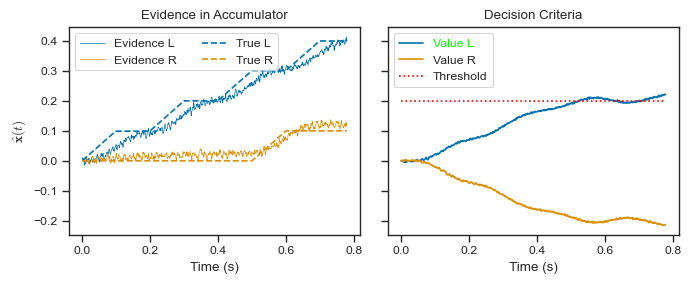

In [19]:
sequential_trial(dP=0.4, ramp=1, threshold=0.2, relative=1, dt_sample=0.1, perception_seed=1)

RT 1.459, cues 15, choice 0, correct 0


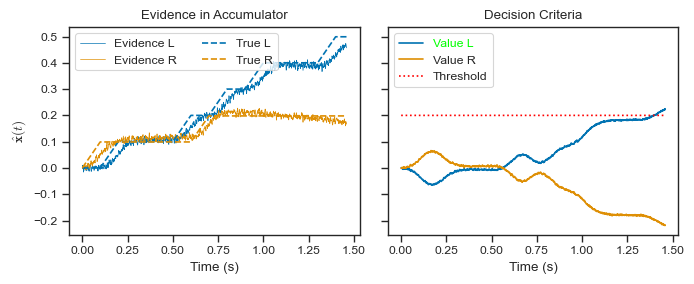

In [30]:
sequential_trial(dP=0.4, ramp=1, threshold=0.2, relative=1, dt_sample=0.1, perception_seed=8)

In [31]:
def double_trial(dP, ramps=[1,1], thresholds=[0.4,0.3], relatives=[1,1], perception_seed=0, network_seed=0, trial=0,
                 dt=0.001, max_cues=12, dt_sample=0.1, rA=1.5, nNeurons=500, legend=True, name="double"):

    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=((7, 4)))
    for i in range(2):
        ramp, threshold, relative = ramps[i], thresholds[i], relatives[i]
        inputs = SequentialPerception(dt_sample=dt_sample, seed=perception_seed+int(dP*10), max_cues=max_cues)
        for t in range(trial):
            inputs.create(dP=dP)  # lines up the input rng as though multiple trials had been previously simulated
        inputs.create(dP=dP)
        # print(inputs.Ps, inputs.sampled)
        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > 2*max_cues*dt_sample-dt:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
        cues = min(int(RT/dt_sample)+1, 2*max_cues)
        print(f"RT {RT}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
    
        for a in range(2):
            axes[i][0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], lw=0.5, label=f"Model {i}") 
        for a in range(2):
            axes[i][1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a]) 
        axes[i][1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label=r'T {i}', color="red", linestyle=":")
        for a in range(2):
            axes[i][0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {a}", linestyle="--") 
    axes[0][0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", title="Cumulative Evidence, "+r"$R=$"+f"{ramps[0]}")
    axes[1][0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Cumulative Evidence, "+r"$R=$"+f"{ramps[1]}")
    axes[0][1].set(title="Value, "+r"$T=$"+f"{thresholds[0]}")
    axes[1][1].set(xlabel="Time (s)", title="Value, "+r"$T=$"+f"{thresholds[1]}")
    axes[1][1].xaxis.set_minor_locator(MultipleLocator(dt_sample))
    # axes[0][0].legend(loc='upper left', ncol=3)
    # axes[0][1].legend(loc='upper left', ncol=2)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

RT 0.35100000000000003, cues 4, choice 1, correct 0
RT 2.273, cues 23, choice 0, correct 0


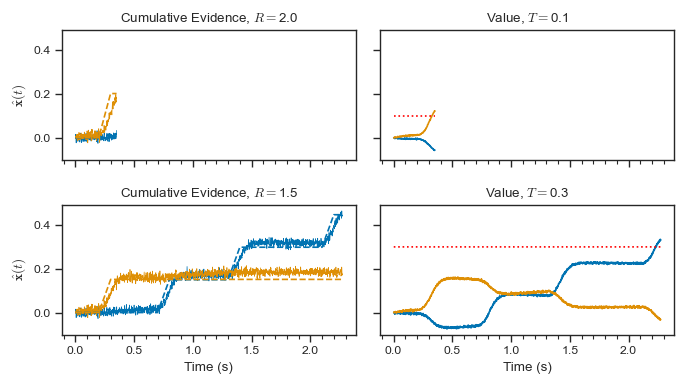

In [32]:
double_trial(dP=0.2, ramps=[2.0, 1.5], thresholds=[0.1, 0.3], relatives=[0.5, 0.5])

# Non-integration Models

In [265]:
def detect_extrema(inputs, cluster_size, positive_only, tiebreaker, seed=0):
    assert cluster_size > 0
    Ls = inputs.sampled[0]
    Rs = inputs.sampled[1]
    # print(Ls)
    # print(Rs)
    target = "L" if np.sum(Ls)>np.sum(Rs) else "R"
    clusterL = []  # stores the size of the cluster at each position
    clusterR = []
    for p in range(len(Ls)):
        currentL = Ls[p]
        currentR = Rs[p]
        if p==0:
            if positive_only:
                cL = currentL
                cR = currentR
            else:
                cL = 1
                cR = 1
        elif p>0:
            lastL = Ls[p-1]
            lastR = Rs[p-1]
            if positive_only:
                cL = 0 if currentL==0 else clusterL[p-1]+1
                cR = 0 if currentR==0 else clusterR[p-1]+1         
            else:
                cL = clusterL[p-1]+1 if (lastL==currentL) else 1
                cR = clusterR[p-1]+1 if (lastR==currentR) else 1        
        clusterL.append(cL)
        clusterR.append(cR)
        # print(clusterL)
        # print(clusterR)
        if clusterL[-1] >= cluster_size:
            if positive_only:
                choice = "L"
            else:
                if currentL==1: # positive cluster, choose this option
                    choice = 'L'
                else:  # negative cluster, choose the other option
                    choice = 'R'
            sampled_cues = 2*(p+1)-1  # assumes L is always presented first
            accuracy = 1.0 if choice==target else 0.0
            return sampled_cues, accuracy, choice
        elif clusterR[-1] >= cluster_size:
            if positive_only:
                choice = "R"
            else:
                if currentR==1: # positive cluster, choose this option
                    choice = 'R'
                else:  # negative cluster, choose the other option
                    choice = 'L'
            sampled_cues = 2*(p+1)  # assumes L is always presented first
            accuracy = 1.0 if choice==target else 0.0
            return sampled_cues, accuracy, choice
     # if no choice is made after max_cues samples are taken, choosen randomly
    rng = np.random.RandomState(seed=seed)
    if tiebreaker=='random':
        choice = ["L", "R"][rng.randint(0,2)]
    elif tiebreaker=='largest':  # choose the option according to the largest cluster, with random tiebreaks
        largestL = np.max(clusterL)
        largestR = np.max(clusterR)
        if largestL > largestR:
            if positive_only:
                choice = "L"
            else:
                value = Ls[np.argmax(clusterL)]
                choice = "L" if value==1 else "R"
        elif largestR > largestL:
            if positive_only:
                choice = "R"
            else:
                value = Rs[np.argmax(clusterR)]
                choice = "R" if value==1 else "L"
        else:
            choice = ["L", "R"][rng.randint(0,2)]
    sampled_cues = len(Ls)+len(Rs)
    accuracy = 1.0 if choice==target else 0.0
    return sampled_cues, accuracy, choice

In [266]:
# seed = 4
# dP = 0.2
# max_cues = 12
# cluster_size = 5
# positive_only = False
# tiebreaker = 'largest'
# inputs = SequentialPerception(seed=seed+int(dP*10), max_cues=max_cues)
# inputs.create(dP=dP)
# detect_extrema(inputs, cluster_size=cluster_size, positive_only=positive_only, tiebreaker=tiebreaker, seed=seed)

In [338]:
def run_all_extrema(dPs=[0.4, 0.2, 0.1], trials=100, cluster_size=3, positive_only=True, seed=0, perception_seed=0, label="all"):
    columns2 = ['type', 'tid', 'dP', 'trial', 'accuracy', 'cues', 'max_cues']
    dfs2 = []
    pid = 0
    for cluster_size in np.arange(1, 7, 1):
        for positive_only in [True, False]:
            for tiebreaker in ['random', 'largest']:
                print(f"pid {pid}, cluster size {cluster_size}, consider only positive values {positive_only}, break ties {tiebreaker}")
                for max_cues in [12, 18]:
                    for dP in dPs:
                        if dP==0.4: difficulty = 'easy'
                        if dP==0.2: difficulty = 'moderate'
                        if dP==0.1: difficulty = 'hard'
                        inputs = SequentialPerception(seed=perception_seed+int(dP*10), max_cues=max_cues)
                        for trial in range(trials):
                            inputs.create(dP=dP)
                            cues, accuracy, choice = detect_extrema(
                                inputs, cluster_size=cluster_size, positive_only=positive_only, tiebreaker=tiebreaker, seed=seed)
                            dfs2.append(pd.DataFrame([['extrema', pid, dP, trial, 100*accuracy, cues, max_cues]], columns=columns2))
                pid += 1
    sim2 = pd.concat(dfs2, ignore_index=True)
    sim2.to_pickle(f"data/extrema_{label}.pkl")

In [334]:
run_all_extrema(trials=500)

pid 0, cluster size 1, consider only positive values True, break ties random
pid 1, cluster size 1, consider only positive values True, break ties largest
pid 2, cluster size 1, consider only positive values False, break ties random
pid 3, cluster size 1, consider only positive values False, break ties largest
pid 4, cluster size 2, consider only positive values True, break ties random
pid 5, cluster size 2, consider only positive values True, break ties largest
pid 6, cluster size 2, consider only positive values False, break ties random
pid 7, cluster size 2, consider only positive values False, break ties largest
pid 8, cluster size 3, consider only positive values True, break ties random
pid 9, cluster size 3, consider only positive values True, break ties largest
pid 10, cluster size 3, consider only positive values False, break ties random
pid 11, cluster size 3, consider only positive values False, break ties largest
pid 12, cluster size 4, consider only positive values True, br

In [357]:
def fit_extrema_to_fiedler(extrfile, empfile, targeted_dPs=[0.2], max_cues=12, cue_step=4, plot=False):
    pd.options.mode.chained_assignment = None
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    dfs = []
    for pid in emp['pid'].unique():
        empirical = emp.query('pid==@pid & max_cues==@max_cues & dP in @targeted_dPs')
        losses = []
        for sid in extr['tid'].unique():
            simulated = extr.query('tid==@sid & max_cues==@max_cues & dP in @targeted_dPs')
            loss = get_targeted_loss(simulated, empirical, targeted_dPs, max_cues, cue_step)
            losses.append(loss)
        best_tid = extr['tid'].unique()[np.argmin(losses)]
        new_extr = extr.query("tid==@best_tid")
        emp_id = empirical['id'].unique()[0]
        id_array_size = new_extr['tid'].to_numpy().shape[0]
        new_extr['id'] = emp_id * np.ones(id_array_size)
        dfs.append(new_extr)
    extr_fit = pd.concat(dfs, ignore_index=True)
    extr_fit.to_pickle(f"data/extrema_fit.pkl")
    if plot:
        bins = np.arange(0, 2*max_cues+cue_step, cue_step)
        combined = pd.concat([emp, extr_fit], ignore_index=True)
        fig = sns.FacetGrid(combined, row="id", col="dP", hue='type',
                        palette=palette[:2], height=1.5, aspect=1.5,
                        col_order=[0.4, 0.2, 0.1])
        fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False)
        # fig.set_xlabels("Cues Sampled Per Trial")
        fig.set_xlabels("Cues")
        fig.set(xticks=bins)  # , yticks=[0, 25, 50, 75, 100]
        fig.add_legend()
        fig.savefig(f"plots/extr_RT_individual_compare.svg")
        fig.savefig(f"plots/extr_RT_individual_compare.png", dpi=600)

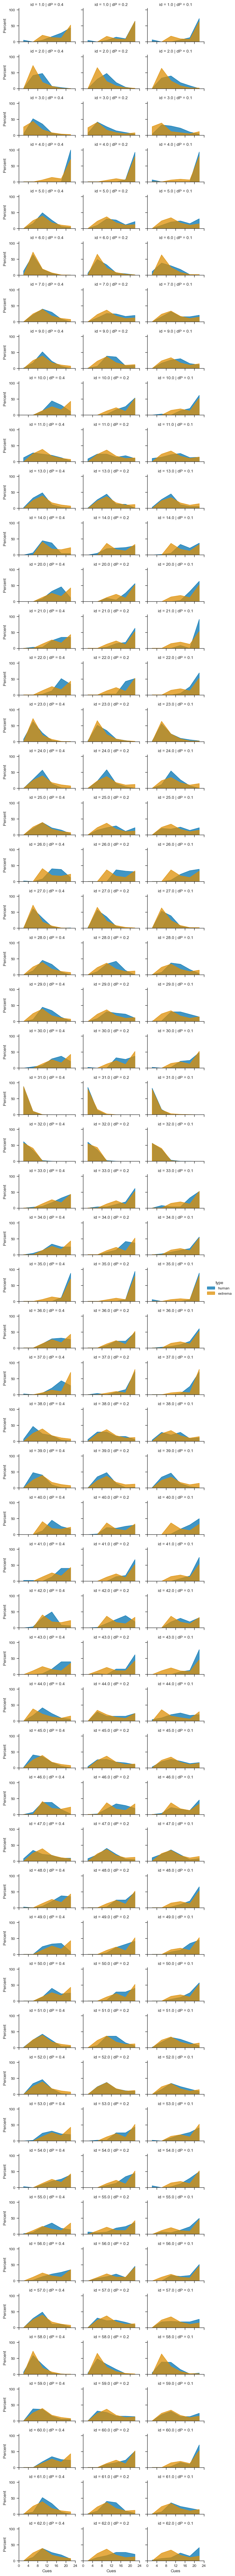

In [358]:
fit_extrema_to_fiedler("extrema_all", "fiedler2", plot=True)

In [361]:
def compare_three_RTs(simfile, extrfile, empfile, dPs=[0.4,0.2,0.1], max_cues=12, cue_step=4):
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    # difficulties = ['easy', 'moderate', 'hard']
    difficulties = [0.4, 0.2, 0.1]
    type_order = ['human', 'model', 'extrema']
    # print(sim)
    # print(extr)
    # print(emp)

    fig = sns.FacetGrid(combined, row="type", col="dP", hue='type',
                        palette=palette[:3], height=1.5, aspect=1.5,
                        row_order=type_order, col_order=difficulties, hue_order=type_order)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False)
    # fig.set_xlabels("Cues Sampled Per Trial")
    fig.set_xlabels("Cues")
    fig.set(xticks=bins)  # , yticks=[0, 25, 50, 75, 100]
    fig.add_legend()
    fig.savefig(f"plots/compare_three_RTs.svg")
    fig.savefig(f"plots/compare_three_RTs.png", dpi=600)

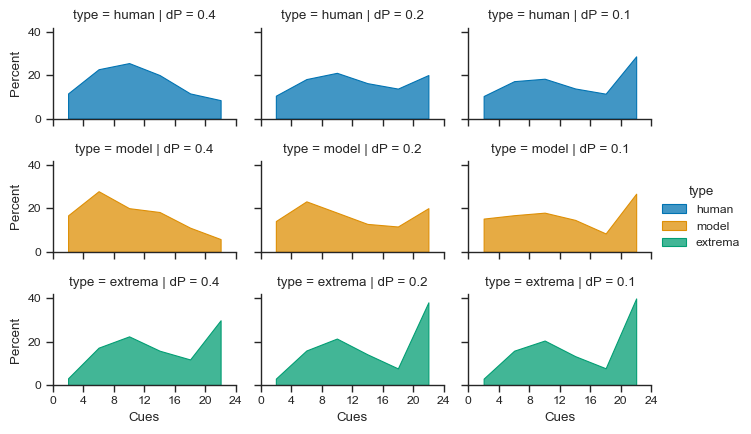

In [362]:
compare_three_RTs("fiedler2_rerun_test_normal_nov29relany", "fiedler2", "extrema_fit", max_cues=12)

In [126]:
# def detect_extrema2(inputs, cluster_size, positive_only, seed=0):
#     assert cluster_size > 1
#     Ls = inputs.sampled[0]
#     Rs = inputs.sampled[1]
#     target = "L" if np.sum(Ls)>np.sum(Rs) else "R"
#     changeL = np.hstack([np.flatnonzero(np.diff(Ls)), len(Ls)-1])
#     changeR = np.hstack([np.flatnonzero(np.diff(Rs)), len(Rs)-1])
#     clusterL = np.hstack([changeL[0]+1, np.diff(changeL)])
#     clusterR = np.hstack([changeR[0]+1, np.diff(changeR)])
#     thrL = np.argwhere(clusterL >= cluster_size).ravel()
#     thrR = np.argwhere(clusterR >= cluster_size).ravel()
#     print(Ls, changeL, clusterL, thrL)
#     print(Rs, changeR, clusterR, thrR)
#     if np.any(thrL) and np.any(thrR):
#         firstL = np.sum(clusterL[:thrL[0]+1])
#         firstR = np.sum(clusterR[:thrR[0]+1])
#         # print(firstL, firstR)
#         choice = "L" if firstL<=firstR else "R"  # assumes L always shown first
#         sampled_cues = firstL + (firstL-1)   # assumes L always shown first
#         correct = 1.0 if choice==target else 0.0
#     elif np.any(thrL):
#         firstL = np.sum(clusterL[:thrL[0]+1])
#         choice = "L"
#         sampled_cues = firstL + (firstL-1)  # assumes L always shown first
#         correct = 1.0 if choice==target else 0.0
#     elif np.any(thrR):
#         firstR = np.sum(clusterR[:thrR[0]+1])
#         choice = "R"
#         sampled_cues = firstR + firstR  # assumes L always shown first
#         correct = 1.0 if choice==target else 0.0
#     else:
#         sampled_cues = len(Ls)+len(Rs)
#         choice = ["L", "R"][rng.randint(0,2)]
#         correct = 1.0 if choice==target else 0.0
#     print(sampled_cues, correct, choice, target)
#     return sampled_cues, correct

# Empirical

In [7]:
def plot_emp_RTs(max_cues, cue_step):
    emp = pd.read_pickle("data/fiedler2.pkl").query("max_cues==@max_cues")
    fig = sns.FacetGrid(emp, row="id", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=np.arange(0, 2*max_cues+cue_step, cue_step), common_norm=False)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_all_RTs_{max_cues}.svg")
    fig.savefig(f"plots/fiedler_all_RTs_{max_cues}.png", dpi=600)

In [9]:
# plot_emp_RTs(max_cues=12, cue_step=4)

In [27]:
def plot_recency_bias(filename, max_cues, aggregate=True):
    emp = pd.read_pickle(f"data/{filename}.pkl").query("max_cues==@max_cues")
    if aggregate:
        fig = sns.FacetGrid(emp, col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2)
        fig.set_xlabels("Cue Position")
        fig.set_ylabels("P(sample $\simeq$ choice)")
        fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))
    else:
        fig = sns.FacetGrid(emp, row="id", col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean)

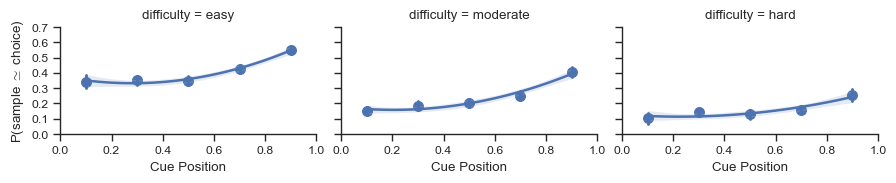

In [28]:
plot_recency_bias("fiedler3", 12)

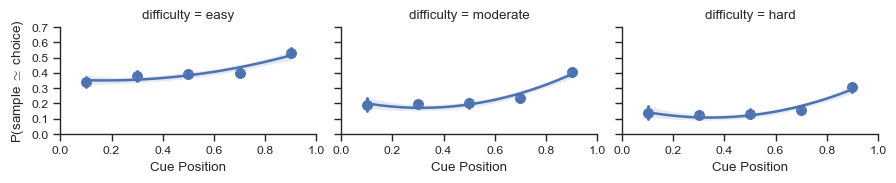

In [59]:
plot_recency_bias("fiedler3", 18)

## Rerun and Compare

In [64]:
def rerun(trained_difficulty, label, dPs=[0.4, 0.2, 0.1], pids=range(57), experiment_time=60, dt=0.001, perception_seed=0, nNeurons=500, rA=1.5,
         dt_sample=0.1, max_cues=12, cue_step=4):

    
    columns1 = ['type', 'pid', 'id', 'difficulty', 'trial', 'position', 'cue', 'value', 'fraction_sampled', 'sampled_cues', 'max_cues', 
            'chosen', 'target', 'accuracy', 'cue_choice_aligned']
    columns2 = ['type', 'id', 'dP', 'trial', 'accuracy', 'cues', 'max_cues']
    dfs1 = []
    dfs2 = []
    for i in pids:
        sid = str(i)
        with open(f"data/fiedler_collect_{trained_difficulty}_{label}.json") as f:
            params = json.load(f)
        param = params[sid]
        ramp = param['ramp']
        threshold = param['threshold']
        relative = param['relative']
        for dP in dPs:
            print(f"id {sid}, dP {dP}")
            if dP==0.4: difficulty = 'easy'
            if dP==0.2: difficulty = 'moderate'
            if dP==0.1: difficulty = 'hard'
            inputs = SequentialPerception(seed=perception_seed+int(dP*10), dt_sample=dt_sample, max_cues=max_cues)
            total_time = 0
            trial = 0
            while total_time < experiment_time:
                inputs.create(dP=dP)
                net = build_network(inputs, seed=trial, ramp=ramp, threshold=threshold, nNeurons=nNeurons, relative=relative, rA=rA)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > 2*max_cues*dt_sample-dt:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                accuracy = 1.0 if choice==net.inputs.correct else 0.0
                chosen = "L" if choice==0 else "R"
                target = "L" if net.inputs.correct==0 else "R"
                cues = min(int(RT/dt_sample)+1, 2*max_cues)
                Ls = net.inputs.sampled[0]
                Rs = net.inputs.sampled[1]
                # print('L', Ls)
                # print("R", Rs)
                for p in range(cues):
                    cue = 'L' if (p % 2 == 0) else 'R'  # L always shown for 500ms, then R is shown for 500ms in our model 
                    if cue == 'R':
                        value = Rs[int(p/2)]
                    elif cue == 'L':
                        value = Ls[int(p/2)]
                    fraction_sampled = (p+1) / cues
                    cue_choice_aligned = 0.0
                    if chosen=='R':
                        if (cue=='R' and value==1) or (cue=='L' and value==0):
                            cue_choice_aligned += 1
                        else:
                            cue_choice_aligned += -1
                    elif chosen=='L':
                        if (cue=='L' and value==1) or (cue=='R' and value==0):
                            cue_choice_aligned += 1
                        else:
                            cue_choice_aligned += -1
                    # print(p, cue, value, fraction_sampled)
                    df1 = pd.DataFrame([[
                        'model', sid, sid, difficulty, trial, p, cue, value, fraction_sampled, cues, max_cues,
                        chosen, target, accuracy, cue_choice_aligned
                        ]], columns=columns1)
                    dfs1.append(df1)
                if cues==0:  # participant chose before sampling any cues
                    df1 = pd.DataFrame([[
                        'model', sid, sid, difficulty, trial, -1, None, None, None, 0, max_cues, chosen, target, accuracy, None
                        ]], columns=columns1)
                    dfs1.append(df1)
                dfs2.append(pd.DataFrame([['model', sid, dP, trial, 100*accuracy, cues, max_cues]], columns=columns2))
                # print(f"pid {pid}, trial {trial}, dP {dP}, elapsed time {total_time}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
                total_time += RT
                trial += 1

    sim1 = pd.concat(dfs1, ignore_index=True)
    sim2 = pd.concat(dfs2, ignore_index=True)
    sim1.to_pickle(f"data/fiedler1_rerun_all_{trained_difficulty}_{label}.pkl")
    sim2.to_pickle(f"data/fiedler2_rerun_all_{trained_difficulty}_{label}.pkl")

In [69]:
def bin_fraction_sampled(simfile):
    data = pd.read_pickle(f"data/{simfile}.pkl")
    bins = np.arange(0.0, 1.2, 0.2)
    columns = ['type', 'pid', 'id', 'difficulty', 'max_cues', 'fraction_sampled', 'mean_cue_choice_aligned', 'std_cue_choice_aligned']
    dfs = []
    for pid in data['pid'].unique():
        sid = data.query('pid==@pid')['id'].unique()[0]
        for difficulty in data['difficulty'].unique():
            for max_cues in data['max_cues'].unique():
                data2 = data.query('pid==@pid & difficulty==@difficulty & max_cues==@max_cues')
                for i in range(len(bins)-1):
                    left = bins[i]
                    right = bins[i+1]
                    midpoint = (left + right) / 2
                    cue_choices_aligned = data2.query('fraction_sampled>@left & fraction_sampled<=@right')['cue_choice_aligned'].to_numpy()
                    mean = np.mean(cue_choices_aligned)
                    std = np.std(cue_choices_aligned)
                    df = pd.DataFrame([[
                        'model', pid, sid, difficulty, max_cues, midpoint, mean, std,
                        ]], columns=columns)
                    dfs.append(df)
    sim = pd.concat(dfs, ignore_index=True)
    sim.to_pickle(f"data/{simfile}_binned.pkl")  # each row contains average and std data from one participant in one condition

In [ ]:
rerun('normal', 'nov29a', experiment_time=60, pids=range(57))

In [72]:
bin_fraction_sampled('normal', 'nov29relany')

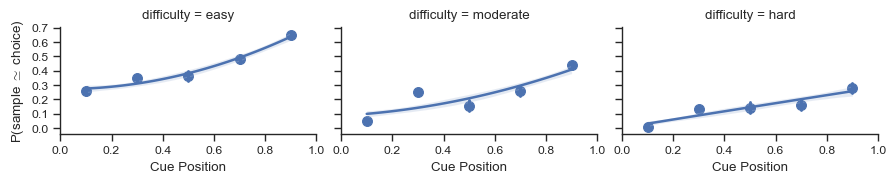

In [74]:
plot_recency_bias("fiedler1_rerun_test_normal_nov29relany_binned", 12)

In [90]:
def plot_combined_recency_bias(filename1, filename2, max_cues):
    emp = pd.read_pickle(f"data/{filename1}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{filename2}.pkl").query("max_cues==@max_cues")
    combined = pd.concat([emp, sim], ignore_index=True)
    fig = sns.FacetGrid(combined, col="difficulty", col_order=["easy", "moderate", "hard"], hue='type', palette=palette, height=3, aspect=1)
    fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2, scatter_kws={'s':10})
    fig.set_xlabels("Cue Position")
    fig.set_ylabels("P(sample $\simeq$ choice)")
    fig.add_legend()
    fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))

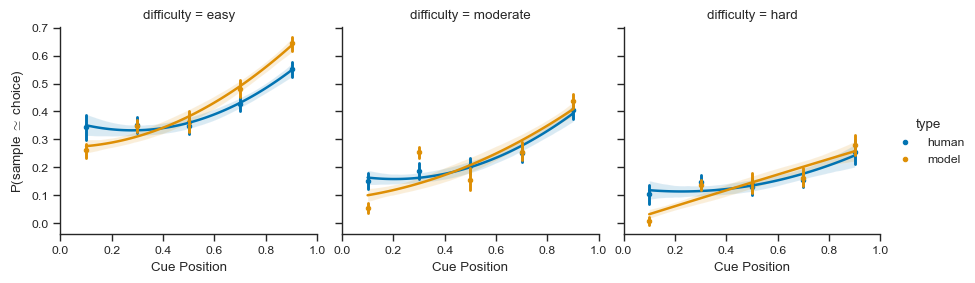

In [91]:
plot_combined_recency_bias("fiedler3", "fiedler1_rerun_test_normal_nov29relany_binned", 12)

In [ ]:
rerun('normal', 'nov29a', experiment_time=60)  # warning: this takes a long time (days)

In [400]:
def compare_three_RTs(simname, empname, extrname, max_cues=12, cue_step=4, replot=[52, 37]):
    sim = pd.read_pickle(f"data/{simname}.pkl").query("max_cues==@max_cues")
    sim['id'] = sim['id'].map({str(replot[0]): replot[0], str(replot[1]): replot[1]})
    emp = pd.read_pickle(f"data/{empname}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrname}.pkl").query("max_cues==@max_cues")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.rename(columns={"dP": "difficulty"})
    # print(combined)
    combined['difficulty'] = combined['difficulty'].map({0.4: 'easy', 0.2: 'normal', 0.1: 'hard'})
    str_replot = str(replot)
    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    difficulties = ['easy', 'normal', 'hard']
    # fig = sns.FacetGrid(combined, row="id", col="dP", col_order=[0.4, 0.2, 0.1], hue='type', palette=palette[:2], height=1.5, aspect=1.5)
    # fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", 
    #                   bins=np.arange(0, 2*max_cues+cue_step, cue_step), common_norm=False)
    # fig.set_xlabels("Cues Sampled Per Trial")
    # fig.add_legend()
    # fig.savefig(f"plots/compare_all_RTs.svg")
    # fig.savefig(f"plots/compare_all_RTs.png", dpi=600)

    fig = sns.FacetGrid(combined.query("id in @replot or id in @str_replot"), row="id", col="difficulty", col_order=difficulties,
                        hue='type', palette=palette[:3], height=1.5, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False)
    # fig.set_xlabels("Cues Sampled Per Trial")
    fig.set_xlabels("Cues")
    fig.set(xticks=bins, yticks=[0, 25, 50, 75, 100])
    fig.add_legend()
    fig.savefig(f"plots/fiedler_extremes.svg")
    fig.savefig(f"plots/fiedler_extremes.png", dpi=600)

    for pid in replot:
        # for dP in [0.4, 0.2, 0.1]:
        for difficulty in difficulties:
            s = combined.query("type=='model' and id==@pid and difficulty==@difficulty")['accuracy'].mean()
            e = combined.query("type=='human' and id==@pid and difficulty==@difficulty")['accuracy'].mean()
            print(pid, difficulty, "human", e, "model", s)

52 easy human 1.0 model 87.91208791208791
52 normal human 0.925 model 72.97297297297297
52 hard human 0.75 model 64.51612903225806
37 easy human 1.0 model 100.0
37 normal human 0.9473684210526315 model 96.66666666666667
37 hard human 0.9523809523809523 model 82.75862068965517


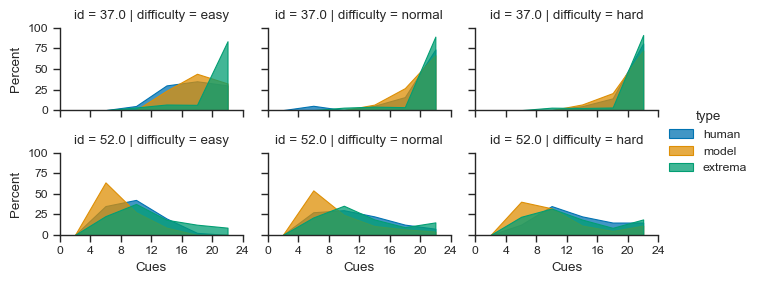

In [401]:
compare_three_RTs("fiedler2_rerun_test_normal_nov29relany", "fiedler2", "extrema_fit")

In [5]:
def compare_RTs(name, max_cues=12, cue_step=4, replot=["52", "37"]):
    sim = pd.read_pickle(f"data/fiedler_rerun_all_{name}.pkl")
    emp = pd.read_pickle("data/fiedler2021.pkl").query("max_cues==@max_cues")
    combined = pd.concat([emp, sim], ignore_index=True)
    combined = combined.rename(columns={"dP": "difficulty"})
    combined['difficulty'] = combined['difficulty'].map({0.4: 'easy', 0.2: 'normal', 0.1: 'hard'})
    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    difficulties = ['easy', 'normal', 'hard']
    # fig = sns.FacetGrid(combined, row="id", col="dP", col_order=[0.4, 0.2, 0.1], hue='type', palette=palette[:2], height=1.5, aspect=1.5)
    # fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", 
    #                   bins=np.arange(0, 2*max_cues+cue_step, cue_step), common_norm=False)
    # fig.set_xlabels("Cues Sampled Per Trial")
    # fig.add_legend()
    # fig.savefig(f"plots/compare_all_RTs.svg")
    # fig.savefig(f"plots/compare_all_RTs.png", dpi=600)

    fig = sns.FacetGrid(combined.query("id in @replot"), row="id", col="difficulty", col_order=difficulties,
                        hue='type', palette=palette[:2], height=1.5, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False)
    # fig.set_xlabels("Cues Sampled Per Trial")
    fig.set_xlabels("Cues")
    fig.set(xticks=bins, yticks=[0, 25, 50, 75, 100])
    fig.add_legend()
    fig.savefig(f"plots/fiedler_extremes.svg")
    fig.savefig(f"plots/fiedler_extremes.png", dpi=600)

    for pid in replot:
        # for dP in [0.4, 0.2, 0.1]:
        for difficulty in difficulties:
            s = combined.query("type=='model' and id==@pid and difficulty==@difficulty")['accuracy'].mean()
            e = combined.query("type=='human' and id==@pid and difficulty==@difficulty")['accuracy'].mean()
            print(pid, difficulty, "human", e, "model", s)

52 easy human 94.44444444444444 model 87.91208791208791
52 normal human 82.14285714285714 model 72.97297297297297
52 hard human 61.111111111111114 model 64.51612903225806
37 easy human 100.0 model 100.0
37 normal human 95.0 model 96.66666666666667
37 hard human 80.0 model 82.75862068965517


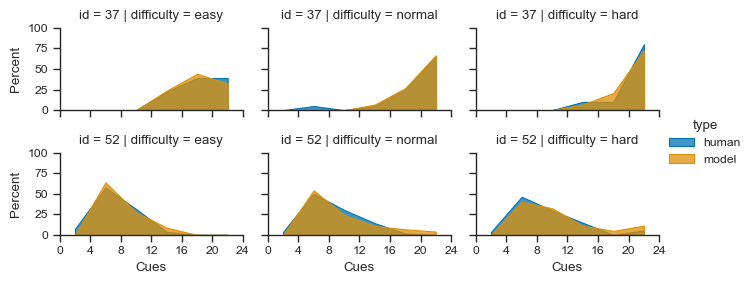

In [60]:
compare_RTs("normal_nov29relany")

In [7]:
def make_collapsed(name, dPs=[0.4,0.2,0.1]):
    sim = pd.read_pickle(f"data/fiedler_rerun_all_{name}.pkl")
    emp = pd.read_pickle("data/fiedler2021.pkl")
    combined = pd.concat([emp, sim], ignore_index=True)    

    dfs = []
    dfs2 = []
    columns = ('type', 'id', 'difficulty', 'max_cues', 'mean cues', 'mean acc', 'nTrials', 'efficiency')
    columns2 = ('type', 'id', 'difficulty', 'max_cues', 'mean cues', 'dependent_var', 'value')
    difficulties = ["easy", "normal", "hard"]
    for type in ['human', 'model']:
        for pid in range(57):
            pidstr = str(pid)
            for i, dP in enumerate(dPs):
                for max_cues in [12, 18]:
                    difficulty = difficulties[i]
                    subdata = combined.query("type==@type & (id==@pid or id==@pidstr) & dP==@dP & max_cues==@max_cues")
                    mean_cues = subdata['cues'].mean()
                    mean_acc = subdata['accuracy'].mean()
                    nTrials = len(subdata['trial'].unique())
                    efficiency = mean_acc * nTrials / 100
                    dfs.append(pd.DataFrame([[type, pid, difficulty, max_cues, mean_cues, mean_acc, nTrials, efficiency]], columns=columns))
                    dfs2.append(pd.DataFrame([[type, pid, difficulty, max_cues, mean_cues, "mean_acc", mean_acc]], columns=columns2))
                    dfs2.append(pd.DataFrame([[type, pid, difficulty, max_cues, mean_cues, "nTrials", nTrials]], columns=columns2))
                    dfs2.append(pd.DataFrame([[type, pid, difficulty, max_cues, mean_cues, "efficiency", efficiency]], columns=columns2))
    collapsed = pd.concat(dfs, ignore_index=True)
    collapsed2 = pd.concat(dfs2, ignore_index=True)
    collapsed.to_pickle(f"data/{name}_collapsed.pkl")
    collapsed2.to_pickle(f"data/{name}_collapsed2.pkl")

In [8]:
def compare_SAT(name, max_cues=12, difficulties=["easy", "normal", "hard"]):
    collapsed2 = pd.read_pickle(f"data/{name}_collapsed2.pkl").query("max_cues==@max_cues")
    fig = sns.FacetGrid(collapsed2, col="difficulty", row='dependent_var', hue='type',
                        sharex=True, sharey='row', col_order=difficulties, palette=palette[:2], height=1.5, aspect=1.5)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="value", s=6)
    fig.set_xlabels("Mean Cues")
    fig.add_legend()
    fig.set(xticks=np.arange(0, max_cues*2+4, 4))
    axes = fig.axes.flatten()
    for ax in axes:
        ax.set(title=None, ylabel=None)
    axes[0].set(title="difficulty = easy")
    axes[1].set(title="difficulty = normal")
    axes[2].set(title="difficulty = hard")
    axes[0].set(ylabel="Mean Accuracy", yticks=[50, 60, 70, 80, 90, 100])
    axes[3].set(ylabel="Total Trials", yticks=[0, 50, 100, 150, 200])
    axes[6].set(ylabel="Total Reward", yticks=[0, 50, 100, 150])
    fig.savefig(f"plots/fiedler_SAT_{name}.svg")
    fig.savefig(f"plots/fiedler_SAT_{name}.png", dpi=600)

In [9]:
def regress_SAT(name, max_cues=12, difficulties=["easy", "normal", "hard"]):
    collapsed = pd.read_pickle(f"data/{name}_collapsed.pkl").query("max_cues==@max_cues")

    fig = sns.FacetGrid(collapsed, col="difficulty", hue='type', col_order=difficulties, palette=palette[:2], height=2, aspect=1.125)
    fig.map_dataframe(sns.regplot, x="mean cues", y="mean acc", scatter_kws={'s': 1})
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(xticks=np.arange(0, max_cues*2+4, 4), yticks=[50, 60, 70, 80, 90, 100], ylim=[40, 110])
    fig.add_legend()
    fig.savefig(f"plots/fiedler_regression_{name}.svg")
    fig.savefig(f"plots/fiedler_regression_{name}.png", dpi=600)

    for difficulty in difficulties:
        x = collapsed.query("difficulty==@difficulty & type=='human'")['mean cues'].to_numpy()
        y = collapsed.query("difficulty==@difficulty & type=='human'")['mean acc'].to_numpy()
        x2 = collapsed.query("difficulty==@difficulty & type=='model'")['mean cues'].to_numpy()
        y2 = collapsed.query("difficulty==@difficulty & type=='model'")['mean acc'].to_numpy()
        res_human = linregress(x, y)
        res_agent = linregress(x2, y2)
        print(difficulty)
        print("human", res_human)
        print("agent", res_agent)
        print(ancova(data=collapsed.query("difficulty==@difficulty"), dv='mean acc', covar='mean cues', between='type'))

In [42]:
def compare_distributions(name, max_cues=12, cue_step=4, acc_step=10, difficulties=["easy", "normal", "hard"]):
    collapsed = pd.read_pickle(f"data/{name}_collapsed.pkl").query("max_cues==@max_cues")

    cues_bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    fig = sns.FacetGrid(collapsed, col="difficulty", hue='type', col_order=difficulties, palette=palette[:2], height=2, aspect=1.2)
    fig.map_dataframe(sns.histplot, x="mean cues", stat='percent', element="poly", bins=cues_bins, common_norm=False)
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Percent")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_cues_distribution_{name}.svg")
    fig.savefig(f"plots/fiedler_cues_distribution_{name}.png", dpi=600)

    acc_bins = np.arange(0, 100+acc_step, acc_step)
    fig = sns.FacetGrid(collapsed, col="difficulty", hue='type', col_order=difficulties, palette=palette[:2], height=2, aspect=1.2)
    fig.map_dataframe(sns.histplot, x="mean acc", stat='percent', element="poly", bins=acc_bins, common_norm=False)
    fig.set_xlabels("Mean Accuracy")
    fig.set_ylabels("Percent")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_acc_distribution_{name}.svg")
    fig.savefig(f"plots/fiedler_acc_distribution_{name}.png", dpi=600)
            
    for DV in ['mean cues', 'mean acc']:
        bins = cues_bins if DV=='mean cues' else acc_bins
        for difficulty in difficulties:
            human = collapsed.query("difficulty==@difficulty & type=='human'")[DV].to_numpy()
            model = collapsed.query("difficulty==@difficulty & type=='model'")[DV].to_numpy()
            hist_human = np.histogram(human, bins=bins)[0]
            hist_model = np.histogram(model, bins=bins)[0]
            normed_human = hist_human / len(human)
            normed_model = hist_model / len(model)
            chi2 = chi_squared_distance(normed_human, normed_model)
            delta_mean = np.abs(np.mean(model) - np.mean(human))
            delta_median = np.abs(np.median(model) - np.median(human))
            print(f"dependent variable:  {DV} \t difficulty:  {difficulty} \t chi-squared:  {chi2:.3}")

In [43]:
def get_errors(name, dPs=[0.4,0.2,0.1], max_cues=12, cue_step=4, acc_step=10, difficulties=["easy", "normal", "hard"]):
    sim = pd.read_pickle(f"data/fiedler_rerun_all_{name}.pkl")
    emp = pd.read_pickle("data/fiedler2021.pkl")
    combined = pd.concat([emp, sim], ignore_index=True)    
    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    for i, dP in enumerate(dPs):
        difficulty = difficulties[i]
        chis = []
        accs = []
        for pid in range(57):
            pidstr = str(pid)
            human = emp.query("type=='human' & id==@pidstr & dP==@dP & max_cues==@max_cues")
            model = sim.query("type=='model' & id==@pidstr & dP==@dP & max_cues==@max_cues")
            hist_human = np.histogram(human['cues'].to_numpy(), bins=bins)[0]
            hist_model = np.histogram(model['cues'].to_numpy(), bins=bins)[0]
            accs_human = human['accuracy'].to_numpy()
            accs_model = model['accuracy'].to_numpy()
            normed_human = hist_human / len(human)
            normed_model = hist_model / len(model)
            chi2 = chi_squared_distance(normed_human, normed_model)
            acc = np.abs(np.mean(accs_human) - np.mean(accs_model))
            chis.append(chi2)
            accs.append(acc)
        print(f"difficulty: {difficulty} \t chi: {np.mean(chis):.3} \t accuracy: {np.mean(accs):.3}")

difficulty: easy 	 chi: 0.173 	 accuracy: 4.06
difficulty: normal 	 chi: 0.142 	 accuracy: 8.74
difficulty: hard 	 chi: 0.17 	 accuracy: 8.78
easy
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967077, pvalue=1.2141203747491597e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=1.2539954334270802, intercept=79.13080019320634, rvalue=0.8718129791005895, pvalue=1.0962668708552116e-18, stderr=0.09500457825437825, intercept_stderr=1.294134488840054)
      Source           SS   DF          F         p-unc       np2
0       type    12.343788    1   0.303517  5.827933e-01  0.002727
1  mean cues  3720.578179    1  91.483903  3.606029e-16  0.451808
2   Residual  4514.282450  111        NaN           NaN       NaN
normal
human LinregressResult(slope=1.5687773565826033, intercept=66.20670768575948, rvalue=0.6877098606661353, pvalue=3.4300196531593667e-09, stderr=0.2233072100394913, intercept_stderr=3.4

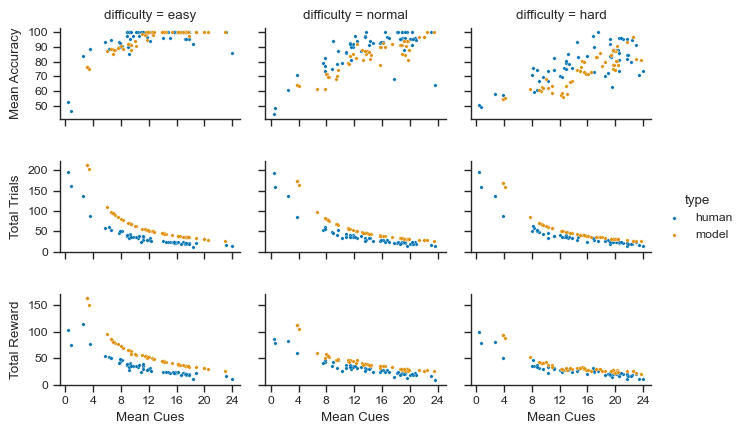

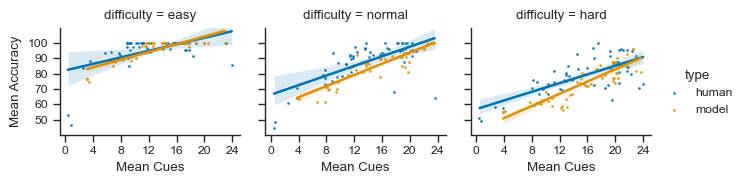

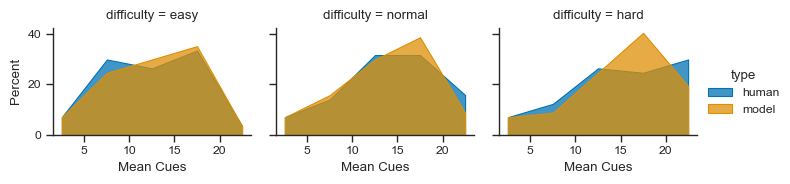

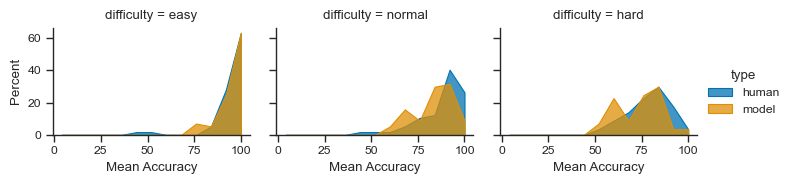

In [44]:
name = "normal_nov29rel0"
get_errors(name)
make_collapsed(name)
compare_SAT(name)
regress_SAT(name)
compare_distributions(name, cue_step=5, acc_step=8)

difficulty: easy 	 chi: 0.314 	 accuracy: 4.01
difficulty: normal 	 chi: 0.268 	 accuracy: 5.98
difficulty: hard 	 chi: 0.243 	 accuracy: 8.03
easy
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967077, pvalue=1.2141203747491597e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=0.8369000002972452, intercept=87.72149676142757, rvalue=0.8833238833981578, pvalue=9.637976466545899e-20, stderr=0.05988605985712974, intercept_stderr=0.6884638165616175)
      Source           SS   DF          F         p-unc       np2
0       type   249.914919    1   6.890954  9.884354e-03  0.058452
1  mean cues  2221.051431    1  61.241495  3.205630e-12  0.355556
2   Residual  4025.648145  111        NaN           NaN       NaN
normal
human LinregressResult(slope=1.5687773565826033, intercept=66.20670768575948, rvalue=0.6877098606661353, pvalue=3.4300196531593667e-09, stderr=0.2233072100394913, intercept_stderr=3.

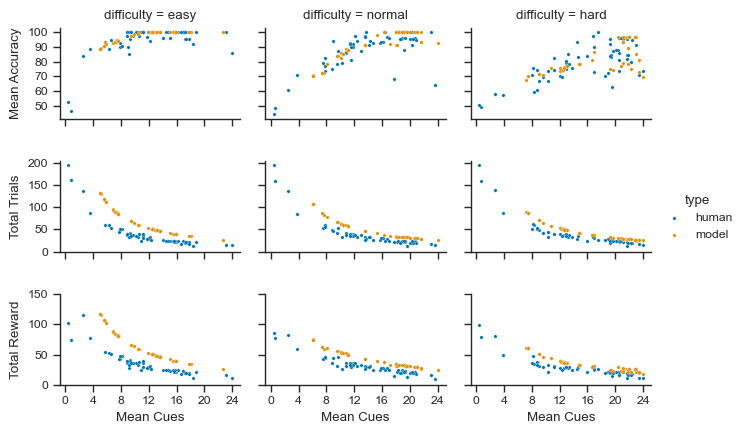

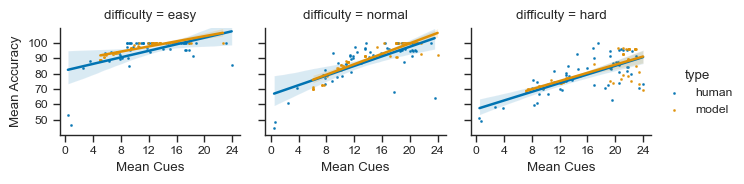

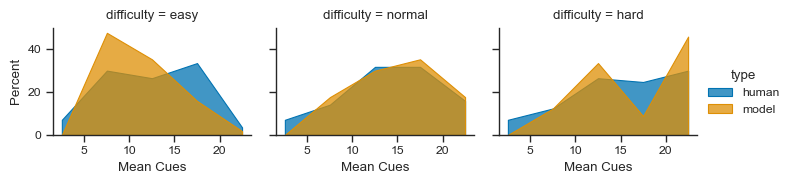

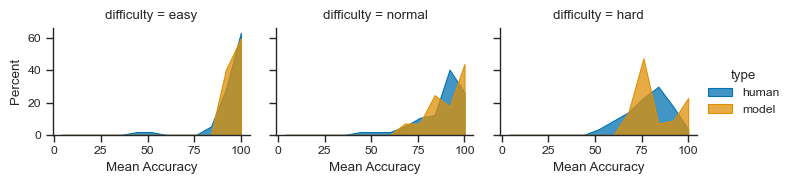

In [45]:
name = "normal_nov29rel1"
get_errors(name)
make_collapsed(name)
compare_SAT(name)
regress_SAT(name)
compare_distributions(name, cue_step=5, acc_step=8)

difficulty: easy 	 chi: 0.165 	 accuracy: 3.6
difficulty: normal 	 chi: 0.123 	 accuracy: 7.13
difficulty: hard 	 chi: 0.168 	 accuracy: 8.51
easy
human LinregressResult(slope=1.066673427929053, intercept=82.12219939294307, rvalue=0.5441391844967077, pvalue=1.2141203747491597e-05, stderr=0.22176830839898767, intercept_stderr=2.917055336979474)
agent LinregressResult(slope=1.3666072318433464, intercept=79.4223356850957, rvalue=0.8336553743261685, pvalue=8.40412255885139e-16, stderr=0.12207846516244106, intercept_stderr=1.5464942293990158)
      Source           SS   DF          F         p-unc       np2
0       type    23.251057    1   0.541760  4.632569e-01  0.004857
1  mean cues  3586.651768    1  83.570552  3.376701e-15  0.429513
2   Residual  4763.859257  111        NaN           NaN       NaN
normal
human LinregressResult(slope=1.5687773565826033, intercept=66.20670768575948, rvalue=0.6877098606661353, pvalue=3.4300196531593667e-09, stderr=0.2233072100394913, intercept_stderr=3.403

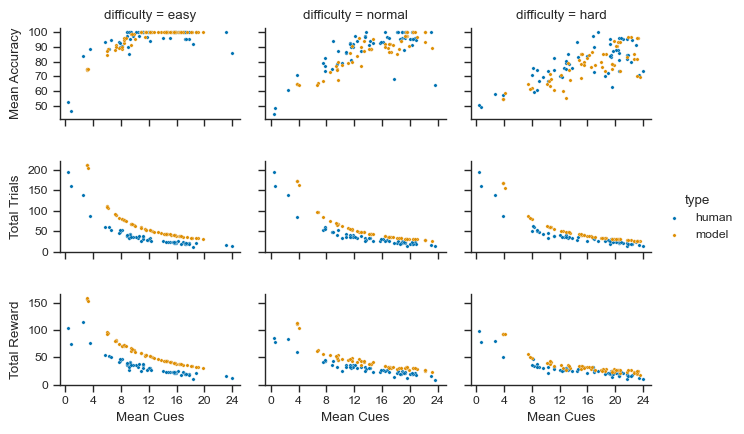

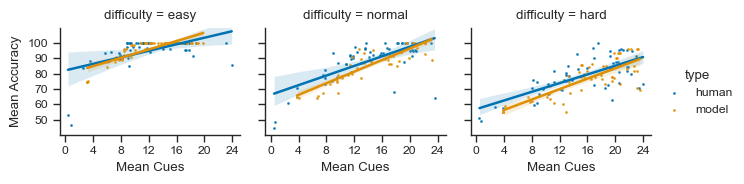

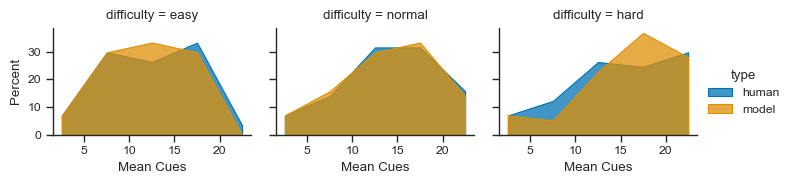

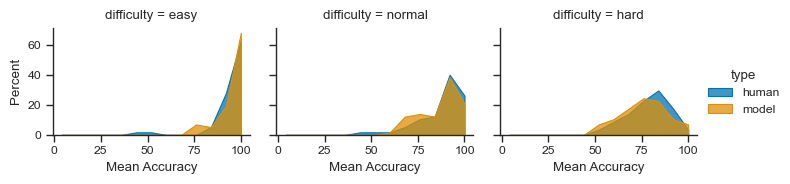

In [46]:
name = "normal_nov29relany"
get_errors(name)
make_collapsed(name)
compare_SAT(name)
regress_SAT(name)
compare_distributions(name, cue_step=5, acc_step=8)